In [2]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt
from source.code import ch3
from source.code import utils

In [3]:
utils.gpu_limitation_config(memory=12)

1. 模仿本节中设计的垂直边缘检测卷积，**手动设计一个水平边缘检测卷积**

In [4]:
#创建图像
X, Y = np.linspace(-2,2,50), np.linspace(-2,2,50)
X, Y = np.meshgrid(X,Y)
image = np.zeros_like(X)
image[X**2 + Y**2 <= 1] = 1 # 圆 x^2 + y^2 <= 1

In [6]:
# 创建2*1水平边缘检测的卷积核
kernel = tf.constant([[1.0], [-1.0]])
H = ch3.corr2d(X=tf.constant(image,dtype=tf.float32),kernel=kernel)

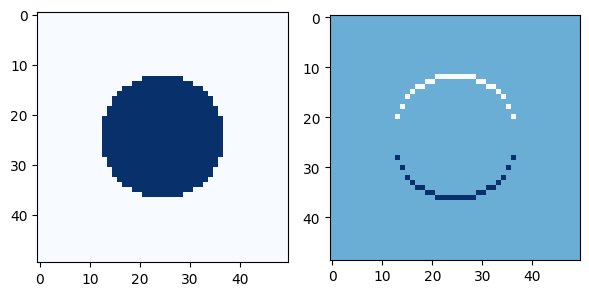

In [7]:
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax = ax.flatten()
ax[0].imshow(image,cmap=plt.cm.Blues) # 原始图像
ax[1].imshow(H.numpy(),cmap=plt.cm.Blues) # 卷积核运算后的结果
plt.tight_layout()

2. 我们再一次深入讨论卷积的计算问题、
   1. 利用 `Tensorflow` 的自动梯度，尝试让我们在3.2.3节中，自定义的 `corr2d()` 的卷积计算输出对卷积核 `kernal` 求梯度，结果是什么？（你可以直接查看 `ch3.corr2d` 的代码）
   2. 理解卷积的运算过程后，尝试改变输入张量`X`和卷积核张量 `kernel` （或者在输入张量和卷积核张量的基础上加工其他变量），将互相关运算 `corr2d()` 表示为**矩阵乘法**
      * 定义**矩阵乘法卷积运算** `MatMultiplyCorr2d()` ，当给定相同的输入和卷积核时，它的输出结果应该与 `corr2d()` 完全相同
      * 函数 `MatMultiplyCorr2d()` 的接口和参数说明已经定义在下方
   3. 尝试让 `MatMultiplyCorr2d()` 的计算输出对卷积核 `kernal` 求梯度，这时候梯度存在吗？

In [8]:
X = tf.constant([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
kernel = tf.constant([[0.0, 1.0], [2.0, 3.0]])

In [9]:
with tf.GradientTape() as tape:
    H = ch3.corr2d(X,kernel)
grad = tape.gradient(H,kernel)
print(grad)

None


梯度不存在？

In [11]:
def MatMultiplyCorr2d(X : tf.Tensor, kernel : tf.Tensor):
    """
    MatMultiplyCorr2d(X : tf.Tensor, kernel : tf.Tensor)
        矩阵乘法实现卷积运算
    
    Parameters
    ----------
    X : tf.Tensor
        输入特征，二维张量，维度`(n_h, n_w)`
    kernel : tf.Tensor
        卷积核，二维张量，维度`(k_h, k_w)`
    """
    # 在下面编写你的代码
    # 你可以参考 corr2d 的实现逻辑
    n_h, n_w = X.shape
    k_h, k_w = kernel.shape
    Y = tf.Variable(tf.zeros((n_h - k_h + 1,n_w - k_w + 1)))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j].assign(tf.reduce_sum(tf.matmul(X[i:i+k_h, j:j+k_w],kernel)))
    return Y

In [13]:
with tf.GradientTape() as tape:
    H2 = MatMultiplyCorr2d(X,kernel)
grad = tape.gradient(H2,kernel)
print(grad)

None


还是不存在？？

3. 完成下面的计算
   1. 假设输入图像的大小是 $16\times 16$，卷积核尺寸 $3\times 5$，使用自动填充（即设定`padding = "same"`），步幅大小 $2\times 2$，则输出图像的大小是多少？
   2. 考虑如下的卷积神经网络结构：
      ```python
      model = tf.keras.models.Sequential([
         tf.keras.layers.Input(shape=(32,32,3)),
         # 第一层卷积
         tf.keras.layers.Conv2D(6,kernel_size=5,padding="same",activation="relu"),
         tf.keras.layers.AvgPool2D(pool_size=2, strides=2),

         # 第二层卷积
         tf.keras.layers.Conv2D(16,kernel_size=3,activation="relu"),
         tf.keras.layers.AvgPool2D(pool_size=2, strides=2),

         # 第三层卷积
         tf.keras.layers.Conv2D(32,kernel_size=3,activation="relu")
      ])
      ```
      请问，**模型最后一层卷积输出的每个像素的感受野是多大**？

1. 输出大小应为 $8 \times 8$

2. 逐层分析
    1. 输入层感受野：1
    2. 第一层的卷积层感受野：$5 \times 5 \times 3$
    3. 第一层的池化层感受野：$6 \times 6 \times 3$
    4. 第二层的卷积层感受野：$10 \times 10 \times3$
    5. 第二层的池化层感受野：$12 \times 12 \times 3$
    6. 第三层的池化层感受野：$20 \times 20 \times 3$